## Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import os
import joblib
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv("Data/features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


## Data Preprocessing

In [3]:
df.shape

(9990, 60)

In [4]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

## Dropping the Unwanted Labels

In [5]:
df = df.drop(labels = 'filename', axis = 1)

## Understanding the Audio Files

In [6]:
audio_recording = "Data/genres_original/country/country.00050.wav"
data, sr = librosa.load(audio_recording)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [7]:
librosa.load(audio_recording, sr = 45600)

(array([ 0.04446703,  0.06373046,  0.05768816, ..., -0.13878521,
        -0.11868109, -0.05903753], dtype=float32),
 45600)

## Spectogram Visualization

/var/folders/l0/k_gmlsbx4c924yygjp7bq3480000gn/T/ipykernel_10687/3742048598.py:4: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft, sr = sr, x_axis = 'time', y_axis = 'hz')


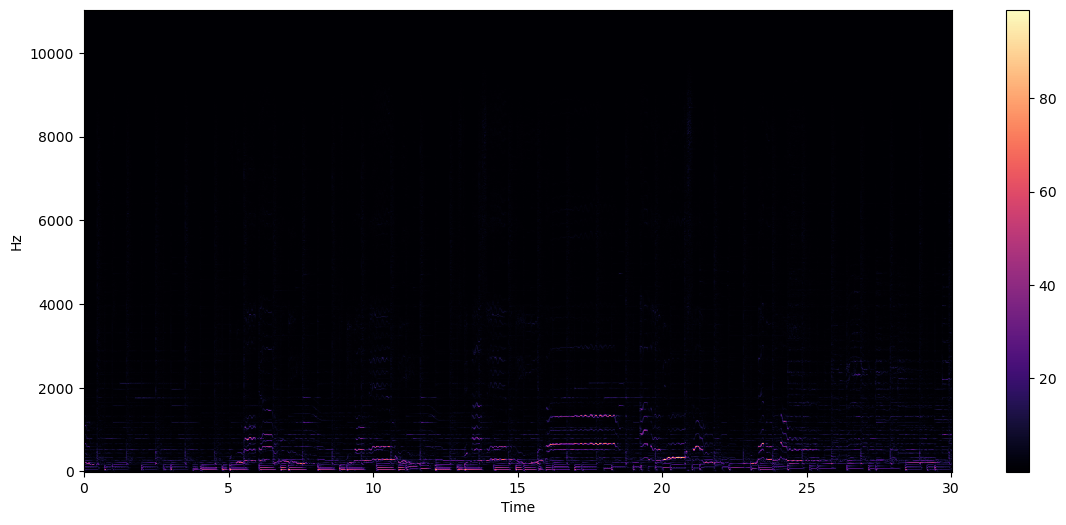

In [8]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize = (14, 6))
librosa.display.specshow(stft, sr = sr, x_axis = 'time', y_axis = 'hz')
plt.colorbar()

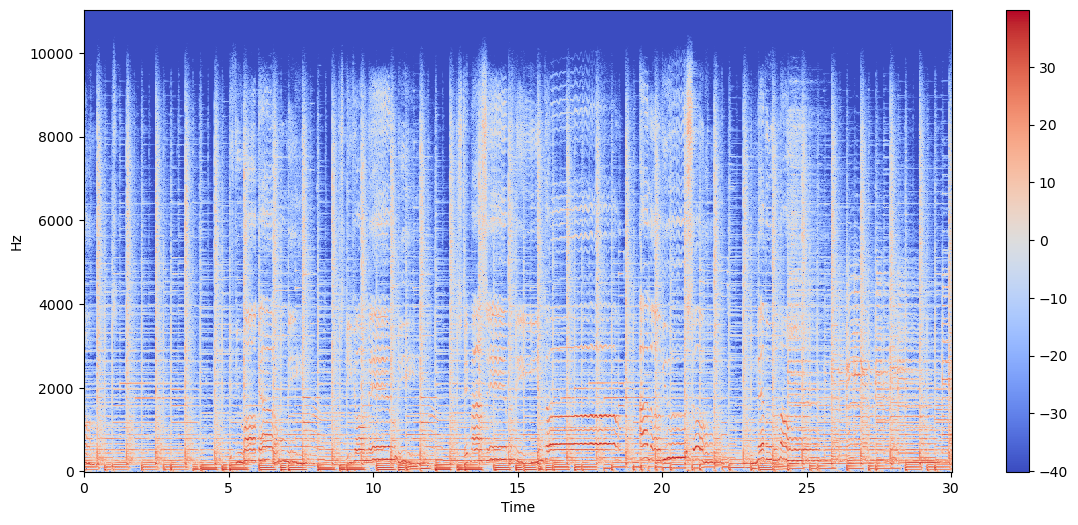

In [9]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize = (14, 6))
librosa.display.specshow(stft_db, sr = sr, x_axis = 'time', y_axis = 'hz')
plt.colorbar()

### Spectral Rolloff

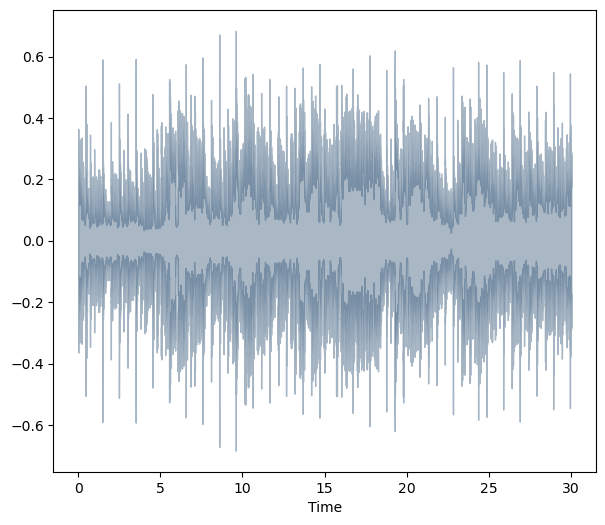

In [10]:
spectral_rolloff = librosa.feature.spectral_rolloff(y = data, sr = sr)[0]
plt.figure(figsize = (7, 6))
librosa.display.waveshow(data, sr = sr, alpha = 0.4, color = '#2B4F72')

### Chroma Feature

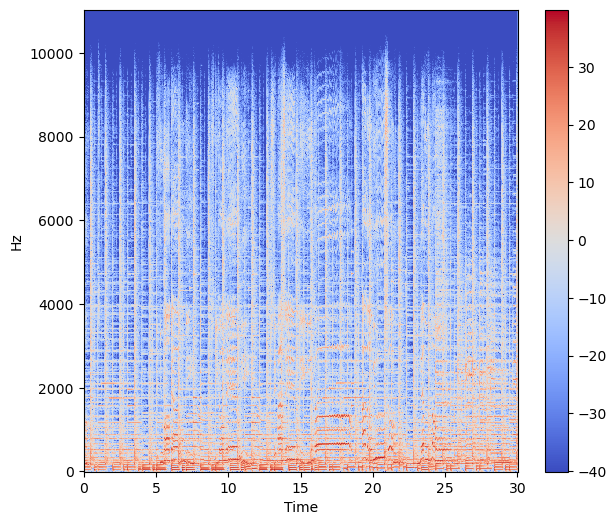

In [11]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize = (7, 6))
librosa.display.specshow(stft_db, sr = sr, x_axis = 'time', y_axis = 'hz')
plt.colorbar()

### Zero Crossing

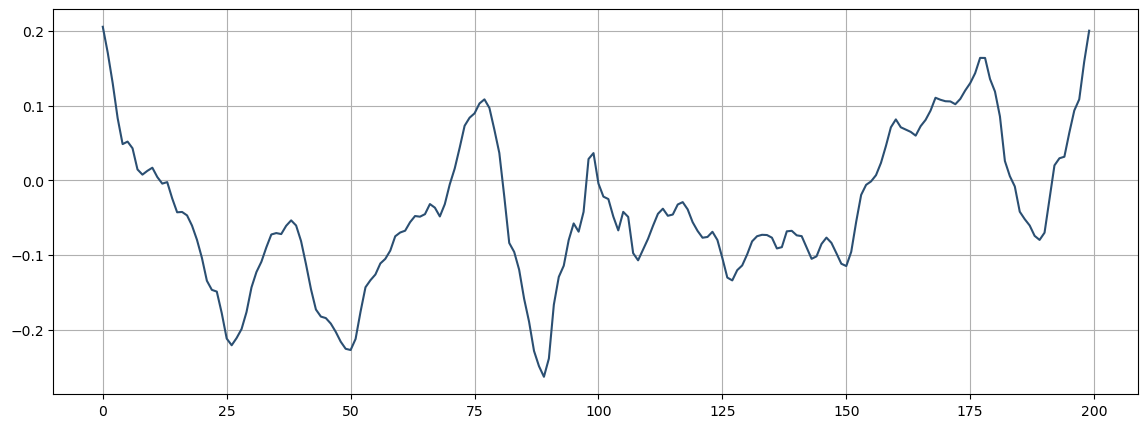

In [12]:
start = 1000
end = 1200
plt.figure(figsize = (14, 5))
plt.plot(data[start : end], color = '#2B4F72')
plt.grid()

In [13]:
zero_cross_rate = librosa.zero_crossings(data[start : end], pad = False)
print("The number of zero-crossings are: ", sum(zero_cross_rate))

The number of zero-crossings are:  8


## Feature Extraction

In [14]:
class_list = df.iloc[: , -1]
convertor = LabelEncoder()

In [15]:
y = convertor.fit_transform(class_list)
np.save("classes.npy", convertor.classes_) # Save class.np

In [16]:
y

array([0, 0, 0, ..., 9, 9, 9])

In [17]:
print(df.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

## Scaling the Features

In [18]:
from sklearn.preprocessing import StandardScaler

fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:, :-1], dtype = float))

In [19]:
X.shape

(9990, 58)

## Dividing the Data into Training and Testing Sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [21]:
len(y_train)

6693

In [22]:
len(y_test)

3297

## Building the Model

In [23]:
from keras.models import Sequential

In [24]:
def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = batch_size)

In [25]:
def plotValidate(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize = (12, 6))
    plt.show()

In [26]:
# import keras as k

In [27]:
model = Sequential([
    keras.layers.Dense(512, activation = 'relu', input_shape = (X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation = 'softmax')
])

In [28]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [29]:
model_history = trainModel(model = model, epochs = 600, optimizer = 'adam')

Epoch 1/600
53/53 [==============================] - 1s 5ms/step - loss: 1.7012 - accuracy: 0.3820 - val_loss: 1.1479 - val_accuracy: 0.5866
Epoch 2/600
53/53 [==============================] - 0s 3ms/step - loss: 1.1773 - accuracy: 0.5893 - val_loss: 0.8798 - val_accuracy: 0.6937
Epoch 3/600
53/53 [==============================] - 0s 3ms/step - loss: 0.9565 - accuracy: 0.6729 - val_loss: 0.7589 - val_accuracy: 0.7361
Epoch 4/600
53/53 [==============================] - 0s 3ms/step - loss: 0.8227 - accuracy: 0.7212 - val_loss: 0.6916 - val_accuracy: 0.7613
Epoch 5/600
53/53 [==============================] - 0s 3ms/step - loss: 0.7203 - accuracy: 0.7626 - val_loss: 0.6082 - val_accuracy: 0.7950
Epoch 6/600
53/53 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.7851 - val_loss: 0.5850 - val_accuracy: 0.7959
Epoch 7/600
53/53 [==============================] - 0s 3ms/step - loss: 0.5794 - accuracy: 0.8091 - val_loss: 0.5479 - val_accuracy: 0.8123
Epoch 8/600
5

## Model Evaluation

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size = 128)
print("The Test Loss is: ", test_loss)
print("\nThe Best Test Accuracy is: ", test_acc*100)

26/26 [==============================] - 0s 1ms/step - loss: 0.5509 - accuracy: 0.9269
The Test Loss is:  0.5508551001548767

The Best Test Accuracy is:  92.6903247833252


/var/folders/l0/k_gmlsbx4c924yygjp7bq3480000gn/T/ipykernel_10687/2536223001.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


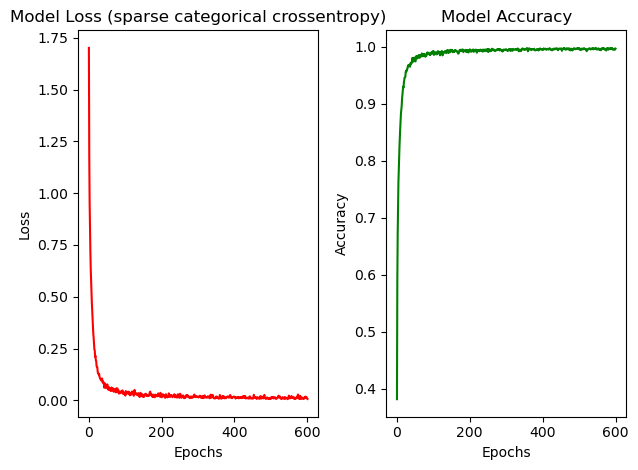

In [31]:
# Training plots
epochs = np.arange(1,601)
plt.subplot(1, 2, 1)
plt.plot(epochs, model_history.history['loss'], color = 'r')
plt.title('Model Loss (sparse categorical crossentropy)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.plot(epochs, model_history.history['accuracy'], color = 'g')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [32]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
preds = []
for i in pred:
    out = np.argmax(i)
    preds.append(out)
cm = confusion_matrix(y_test, preds)

104/104 [==============================] - 0s 700us/step


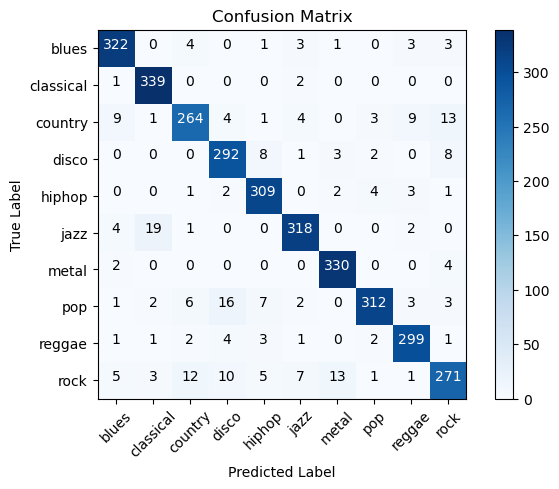

In [33]:
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = convertor.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment = "center",
             color = "white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Validation and Testing

In [34]:
# Validation
print(model.layers[0].input_shape)
def predict(model, X, Y):
    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    print(prediction)
    predicted_index = np.argmax(prediction, axis = 1)
    print("Expected Index :", Y)
    print("Prediction Index :", predicted_index)
# Testing
X = X_test[150] 
Y = y_test[150]
predict(model, X, Y)

(None, 58)
1/1 [==============================] - 0s 13ms/step
[[4.5286557e-09 2.6915289e-10 8.0281101e-11 2.4798582e-03 4.7778908e-08
  1.6534678e-11 6.2427510e-08 4.7426041e-10 1.3085030e-10 9.9752003e-01]]
Expected Index : 9
Prediction Index : [9]


In [39]:
model.save('my_model.h5')

In [40]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()

scaler.fit(X_train)

joblib.dump(scaler, 'scaler.joblib')

scaler = joblib.load('scaler.joblib')

X_test_scaled = scaler.transform(X_test)

In [41]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
import numpy as np
import librosa
from joblib import load

model = keras.models.load_model('my_model.h5')
le = LabelEncoder()
le.classes_ = np.load('classes.npy', allow_pickle = True)
fit = load('scaler.joblib')

def extract_features(filename):
    y, sr = librosa.load(filename, duration = 30)
    length = 66149
    chroma_stft_mean = librosa.feature.chroma_stft(y = y, sr = sr).mean()
    chroma_stft_var = librosa.feature.chroma_stft(y = y, sr = sr).var()
    rms_mean = librosa.feature.rms(y = y).mean()
    rms_var = librosa.feature.rms(y = y).var()
    spectral_centroid_mean = librosa.feature.spectral_centroid(y = y, sr = sr).mean()
    spectral_centroid_var = librosa.feature.spectral_centroid(y = y, sr = sr).var()
    spectral_bandwidth_mean = librosa.feature.spectral_bandwidth(y = y, sr = sr).mean()
    spectral_bandwidth_var = librosa.feature.spectral_bandwidth(y = y, sr = sr).var()
    rolloff_mean = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    rolloff_var = librosa.feature.spectral_rolloff(y=y, sr=sr).var()
    zero_crossing_rate_mean = librosa.feature.zero_crossing_rate(y=y).mean()
    zero_crossing_rate_var = librosa.feature.zero_crossing_rate(y=y).var()
    y_harmonic = librosa.effects.harmonic(y)
    harmony_mean = np.mean(y_harmonic)
    harmony_var = np.var(y_harmonic)
    y_percussive = librosa.effects.percussive(y)
    perceptr_mean = np.mean(y_percussive)
    perceptr_var = np.var(y_percussive)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc1_mean = mfccs[0].mean()
    mfcc1_var = mfccs[0].var()
    mfcc2_mean = mfccs[1].mean()
    mfcc2_var = mfccs[1].var()
    mfcc3_mean = mfccs[2].mean()
    mfcc3_var = mfccs[2].var()
    mfcc4_mean = mfccs[3].mean()
    mfcc4_var = mfccs[3].var()
    mfcc5_mean = mfccs[4].mean()
    mfcc5_var = mfccs[4].var()
    mfcc6_mean = mfccs[5].mean()
    mfcc6_var = mfccs[5].var()
    mfcc7_mean = mfccs[6].mean()
    mfcc7_var = mfccs[6].var()
    mfcc8_mean = mfccs[7].mean()
    mfcc8_var = mfccs[7].var()
    mfcc9_mean = mfccs[8].mean()
    mfcc9_var = mfccs[8].var()
    mfcc10_mean = mfccs[9].mean()
    mfcc10_var = mfccs[9].var()
    mfcc11_mean = mfccs[10].mean()
    mfcc11_var = mfccs[10].var()
    mfcc12_mean = mfccs[11].mean()
    mfcc12_var = mfccs[11].var()
    mfcc13_mean = mfccs[12].mean()
    mfcc13_var = mfccs[12].var()
    mfcc14_mean = mfccs[13].mean()
    mfcc14_var = mfccs[13].var()
    mfcc15_mean = mfccs[14].mean()
    mfcc15_var = mfccs[14].var()
    mfcc16_mean = mfccs[15].mean()
    mfcc16_var = mfccs[15].var()
    mfcc17_mean = mfccs[16].mean()
    mfcc17_var = mfccs[16].var()
    mfcc18_mean = mfccs[17].mean()
    mfcc18_var = mfccs[17].var()
    mfcc19_mean = mfccs[18].mean()
    mfcc19_var = mfccs[18].var()
    mfcc20_mean = mfccs[19].mean()
    mfcc20_var = mfccs[19].var()
    
    features = np.array([length, chroma_stft_mean, chroma_stft_var, rms_mean, rms_var, spectral_centroid_mean, spectral_centroid_mean,
                        spectral_centroid_var, spectral_bandwidth_mean, spectral_bandwidth_var, rolloff_mean, rolloff_var, zero_crossing_rate_mean,
                         zero_crossing_rate_var, harmony_mean, harmony_var, perceptr_mean, perceptr_var, tempo, mfcc1_mean, mfcc1_var,
                         mfcc2_mean, mfcc2_var, mfcc3_mean, mfcc3_var, mfcc4_mean, mfcc4_var, mfcc5_mean, mfcc5_var, mfcc6_mean, mfcc6_var,
                         mfcc7_mean, mfcc7_var, mfcc8_mean, mfcc8_var, mfcc9_mean, mfcc9_var, mfcc10_mean, mfcc10_var, mfcc11_mean, mfcc11_var,
                         mfcc12_mean, mfcc12_var, mfcc13_mean, mfcc13_var, mfcc14_mean, mfcc14_var, mfcc15_mean, mfcc15_var, mfcc16_mean, mfcc16_var,
                         mfcc17_mean, mfcc17_var, mfcc18_mean, mfcc18_var, mfcc19_mean, mfcc19_var, mfcc20_mean, mfcc20_var])
    return features
    
def classify_audio():
    filename = filedialog.askopenfilename()
    if filename:
        X = extract_features(filename)
        X = np.expand_dims(X, axis=0)
        X = fit.transform(X)
        y_pred = model.predict(X)
        predicted_index = le.classes_[np.argmax(y_pred, axis=1)]
        global predicted_genre
        predicted_genre = predicted_index[0]
        result_label = tk.Label(window, text='the genre for your music is', font = ("Helvetica",20))
        result_label.pack()
        result_label = tk.Label(window, text = predicted_genre, font = ("Helvetica",20))
        result_label.pack(pady=20)
        
window = tk.Tk()
window.geometry("900x600")
window.title('Audio Genre Classification')

load_button = tk.Button(window, text='Load Audio File', command=classify_audio)
load_button.pack(pady=20)


window.mainloop() 